### Hypothesis 0

Generally, we want to investigate whether increasing depth of an encoder will let it remember acoustic features that allows it to remember the acoustic structure in the recordings

I train only ReLU activation functions as the others didn't seem to work correctly. I take two models that shown optimal results in -1 and autoencoder we would like to investigate

model list:
- dense_timed_simplest_dilated with separate axes
- dense_timed_simplest_dilated with common axes
- convolutional autoencoder from experiment -1
- variations on the same autoencoder with different depths of encoding

Keras optimizers for 0.001, 0.0001, 0.00001
9000 recordings
prepare the gsm.wavs
mean not removed, divided by STD, range from 0 to one digit number
if in 4 epochs the model doesnt improve == it has converged in that stage (change from 8 for faster convergence - we train multistage after all)

##### Imports and initialization

In [1]:
%matplotlib inline

import os,sys
#path = os.path.realpath(os.path.join(os.getcwd(), ".."))
path = "/home/zantyr/Denoising"
sys.path.append(path)
os.chdir(path)

import matplotlib.pyplot as plt
import numpy as np
import pickle
import scipy.io.wavfile as sio
import tempfile

from IPython.display import Image, Audio, display

import keras
from keras.utils.vis_utils import plot_model
from keras.layers         import Dropout, Input, Conv1D, Conv2D, AveragePooling2D, Flatten, Dense, Deconv2D, UpSampling2D, concatenate, BatchNormalization, Lambda, LeakyReLU, TimeDistributed, Reshape, LSTM, GaussianNoise
from keras.models         import Model
from keras.datasets.mnist import load_data
from keras.utils          import to_categorical
from keras.initializers   import Orthogonal
from keras.regularizers   import L1L2, l2
from keras.callbacks      import Callback
import keras.backend as K
import tensorflow as tf

import loaders
from loaders.transform import AddGaussianNoise, Windowing, GSMize, MixReverb, MixNoise, ConstantQTransform, Transcript, LengthOfWindow, Length, Lengthen, Null, DivisiblePad
from loaders.dataset import Dataset, enable_multiprocessing, disable_multiprocessing
from loaders.feature import NormalizedLogPowerRFFT, Trim
from loaders.experiment import SingleExperiment
from loaders.measures import MSE
from loaders.schedule import Schedule
from loaders.estimator import DefaultVisualizeTransform, Estimator
from loaders.extras import LossHistory, set_device, delog_griffin_lim, get_stft
from loaders.custom import identity_loss
set_device()               # switches to CPU if GPU busy
enable_multiprocessing()   # for faster preprocessing of data (multicore)

Using TensorFlow backend.


Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Switching to CPU only as GPU is busy or unavailable


Process ForkPoolWorker-9:
Traceback (most recent call last):
Process ForkPoolWorker-7:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.6/site-packages/multiprocess/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/site-packages/multiprocess/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/site-packages/multiprocess/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/site-packages/multiprocess/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/site-packages/multiprocess/pool.py", line 108, in worker
    task = get()
  File "/usr/lib/python3.6/site-packages/multiprocess/queues.py", line 345, in get
    with self._rlock:
  File "/usr/lib/python3.6/site-packages/multiprocess/pool.py", line 108, in worker
    task = get()
  File "/usr/lib/python3.6/site-packages/multiprocess/synchronize.

##### Model definition

In [13]:
model_callbacks = []

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_lf (InputLayer)           (None, None, 129)    0                                            
__________________________________________________________________________________________________
lambda_10 (Lambda)              (None, None, 129, 1) 0           input_lf[0][0]                   
__________________________________________________________________________________________________
conv2d_31 (Conv2D)              (None, None, 129, 16 160         lambda_10[0][0]                  
__________________________________________________________________________________________________
leaky_re_lu_55 (LeakyReLU)      (None, None, 129, 16 0           conv2d_31[0][0]                  
__________________________________________________________________________________________________
conv2d_32 

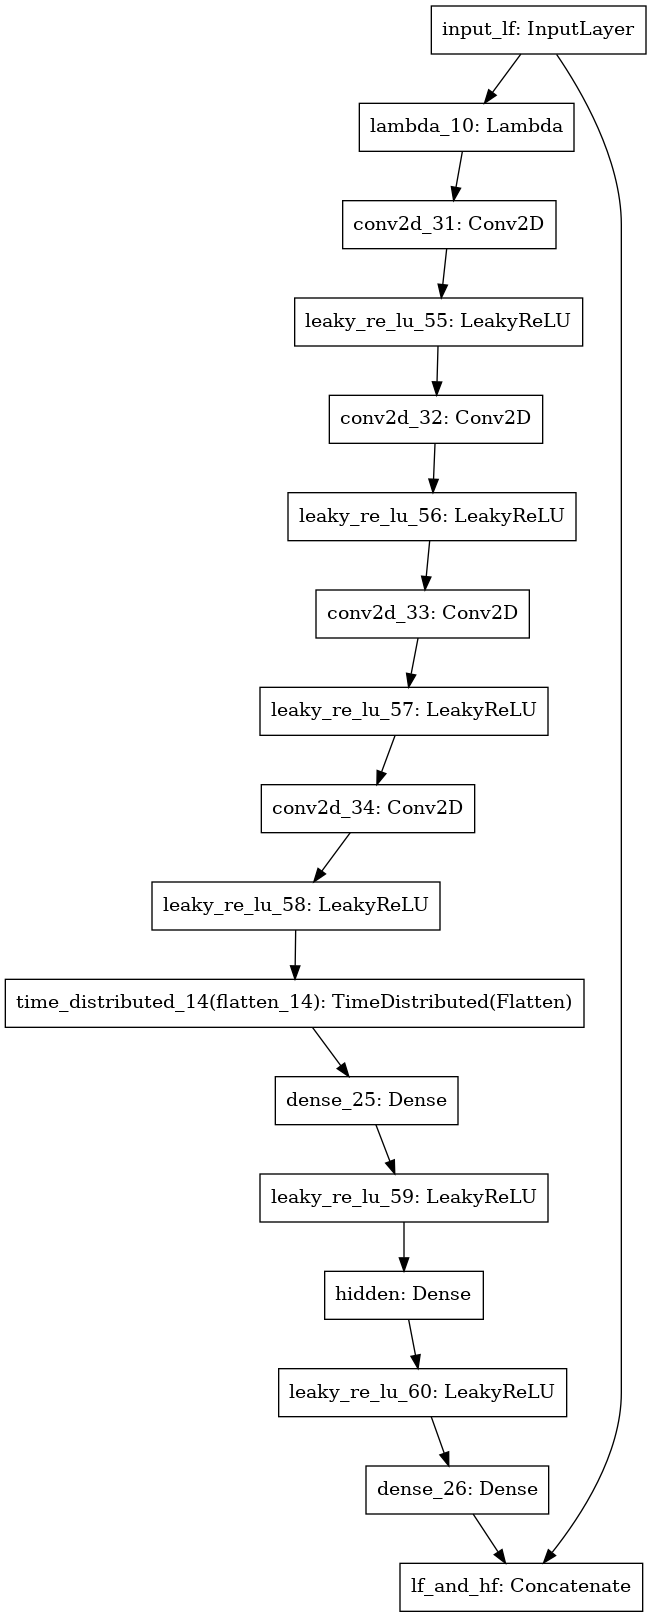

In [14]:
def mk_model():
    input_lower = Input((None, 129), name="input_lf")
    layer = Lambda(lambda x: K.expand_dims(x))(input_lower)
    layer = LeakyReLU(0.05)(Conv2D(16, kernel_size=(9,1), padding='same', activation='linear')(layer))
    layer = LeakyReLU(0.05)(Conv2D(20, kernel_size=(1,5), padding='same', activation='linear')(layer))
    layer = LeakyReLU(0.05)(Conv2D(24, kernel_size=(9,1), padding='same', activation='linear')(layer))
    layer = LeakyReLU(0.05)(Conv2D(28, kernel_size=(1,5), padding='same', activation='linear')(layer))
    layer = TimeDistributed(Flatten())(layer)
    layer = LeakyReLU(0.05)(Dense(1024)(layer))
    layer = LeakyReLU(0.05)(Dense(512, name='hidden')(layer))
    layer = Dense(128)(layer)
    lf_and_hf = concatenate([input_lower, layer], name="lf_and_hf")
    mdl = Model(input_lower, lf_and_hf)
    mdl.summary()
    mdl.compile('adam', 'mse')
    return mdl

temp = tempfile.mktemp() + ".png"
mdl = mk_model()
model_callbacks.append(mk_model)
plot_model(mdl, to_file=temp)
Image(filename=temp)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_lf (InputLayer)           (None, None, 129)    0                                            
__________________________________________________________________________________________________
lambda_11 (Lambda)              (None, None, 129, 1) 0           input_lf[0][0]                   
__________________________________________________________________________________________________
conv2d_35 (Conv2D)              (None, None, 129, 32 1472        lambda_11[0][0]                  
__________________________________________________________________________________________________
leaky_re_lu_61 (LeakyReLU)      (None, None, 129, 32 0           conv2d_35[0][0]                  
__________________________________________________________________________________________________
conv2d_36 

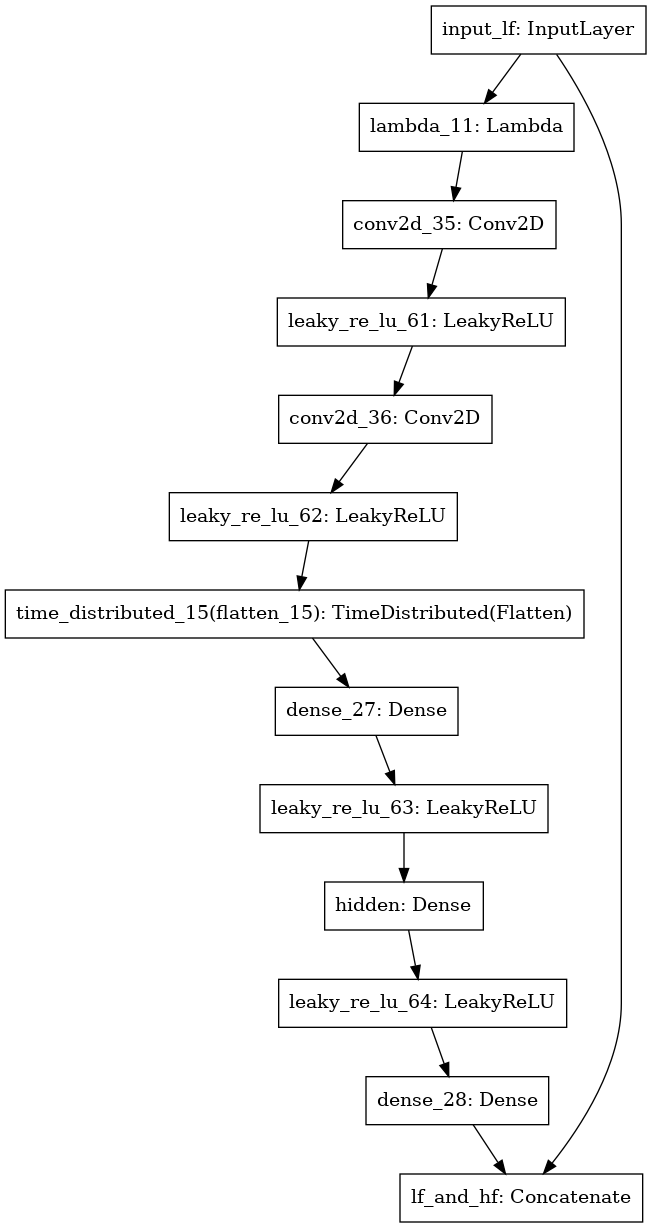

In [15]:
def mk_model():
    input_lower = Input((None, 129), name="input_lf")
    layer = Lambda(lambda x: K.expand_dims(x))(input_lower)
    layer = LeakyReLU(0.05)(Conv2D(32, kernel_size=(9,5), padding='same', activation='linear')(layer))
    layer = LeakyReLU(0.05)(Conv2D(40, kernel_size=(9,5), padding='same', activation='linear')(layer))
    layer = TimeDistributed(Flatten())(layer)
    layer = LeakyReLU(0.05)(Dense(1024)(layer))
    layer = LeakyReLU(0.05)(Dense(512, name='hidden')(layer))
    layer = Dense(128)(layer)
    lf_and_hf = concatenate([input_lower, layer], name="lf_and_hf")
    mdl = Model(input_lower, lf_and_hf)
    mdl.summary()
    mdl.compile('adam', 'mse')
    return mdl

temp = tempfile.mktemp() + ".png"
mdl = mk_model()
model_callbacks.append(mk_model)
plot_model(mdl, to_file=temp)
Image(filename=temp)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_lf (InputLayer)           (None, None, 129)    0                                            
__________________________________________________________________________________________________
lambda_12 (Lambda)              (None, None, 129, 1) 0           input_lf[0][0]                   
__________________________________________________________________________________________________
conv2d_37 (Conv2D)              (None, None, 129, 16 160         lambda_12[0][0]                  
__________________________________________________________________________________________________
conv2d_38 (Conv2D)              (None, None, 129, 20 1620        conv2d_37[0][0]                  
__________________________________________________________________________________________________
leaky_re_l

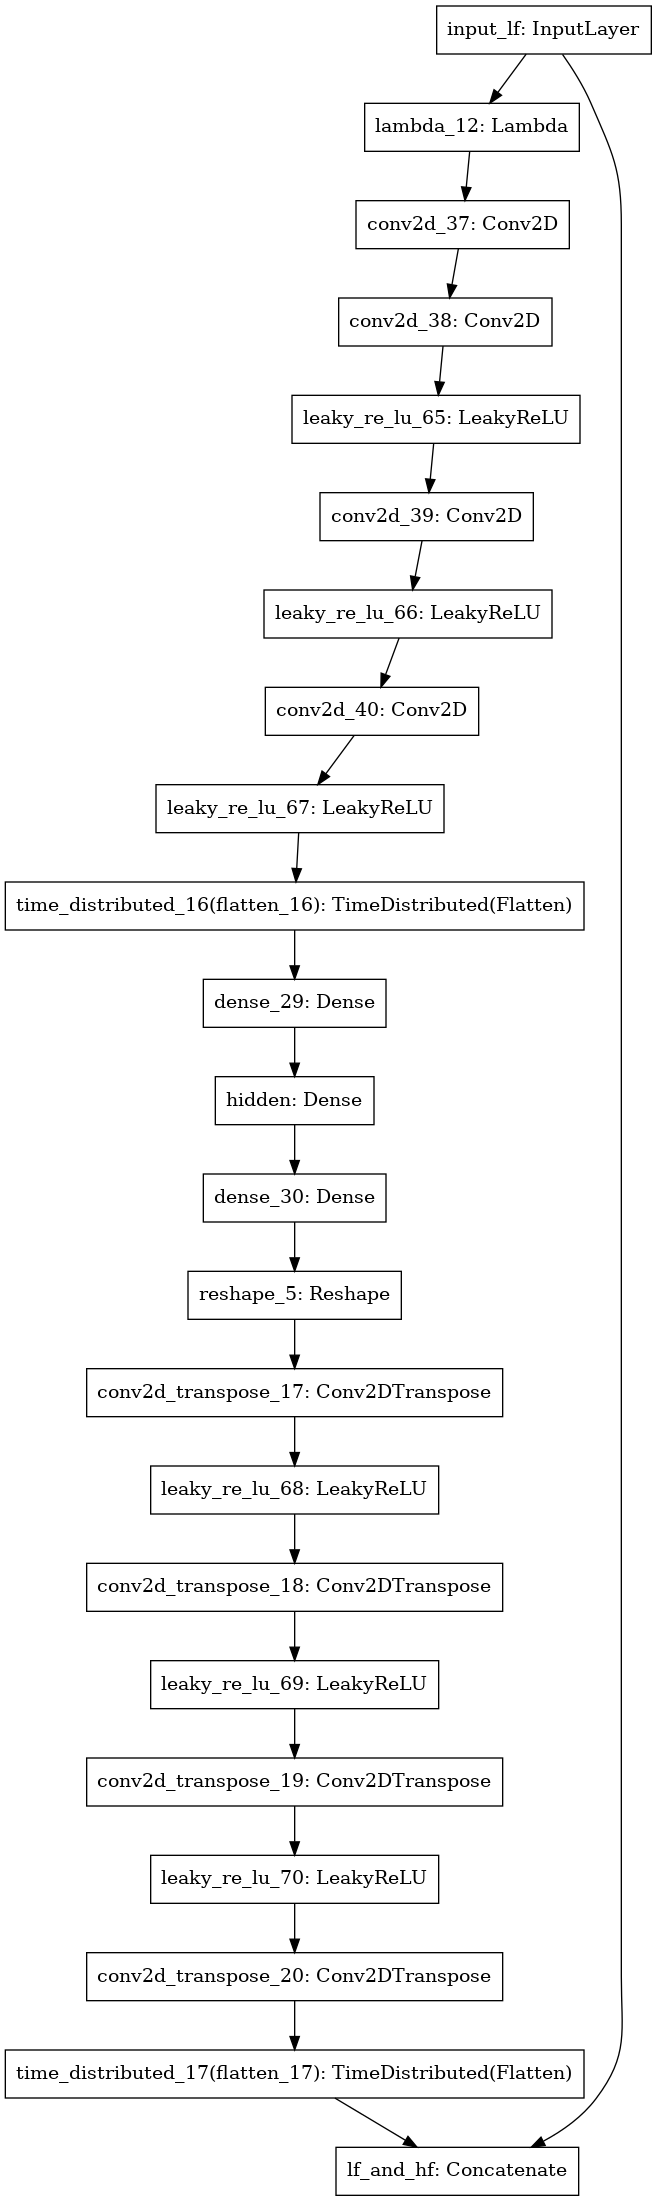

In [16]:
# baseline autoencoder

def mk_model():
    input_lower = Input((None, 129), name="input_lf")
    layer = Lambda(lambda x: K.expand_dims(x))(input_lower)
    layer = Conv2D(16, kernel_size=(9,1), padding='same', activation='tanh')(layer)
    layer = LeakyReLU(0.05)(Conv2D(20, kernel_size=(1,5), padding='same', activation='linear')(layer))
    layer = LeakyReLU(0.05)(Conv2D(24, kernel_size=(9,1), padding='same', activation='linear')(layer))
    layer = LeakyReLU(0.05)(Conv2D(28, kernel_size=(1,5), padding='same', activation='linear')(layer))
    layer = TimeDistributed(Flatten())(layer)
    layer = Dense(1024, activation='tanh')(layer)
    layer = Dense(96, activation='tanh', name='hidden')(layer)
    layer = Dense(1024, activation='tanh')(layer)
    layer = Reshape((-1, 128,8))(layer)
    layer = LeakyReLU(0.05)(Deconv2D(28, kernel_size=(1,5), padding='same', activation='linear')(layer))
    layer = LeakyReLU(0.05)(Deconv2D(24, kernel_size=(9,1), padding='same', activation='linear')(layer))
    layer = LeakyReLU(0.05)(Deconv2D(20, kernel_size=(1,5), padding='same', activation='linear')(layer))
    layer = Deconv2D(1, kernel_size=(9,1), padding='same', activation='linear')(layer)
    layer = TimeDistributed(Flatten())(layer)
    lf_and_hf = concatenate([input_lower, layer], name="lf_and_hf")
    mdl = Model(input_lower, lf_and_hf)
    mdl.summary()
    mdl.compile('adam', 'mse')
    return mdl

temp = tempfile.mktemp() + ".png"
mdl = mk_model()
model_callbacks.append(mk_model)
plot_model(mdl, to_file=temp)
Image(filename=temp)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_lf (InputLayer)           (None, None, 129)    0                                            
__________________________________________________________________________________________________
lambda_13 (Lambda)              (None, None, 129, 1) 0           input_lf[0][0]                   
__________________________________________________________________________________________________
conv2d_41 (Conv2D)              (None, None, 129, 16 160         lambda_13[0][0]                  
__________________________________________________________________________________________________
leaky_re_lu_71 (LeakyReLU)      (None, None, 129, 16 0           conv2d_41[0][0]                  
__________________________________________________________________________________________________
conv2d_42 

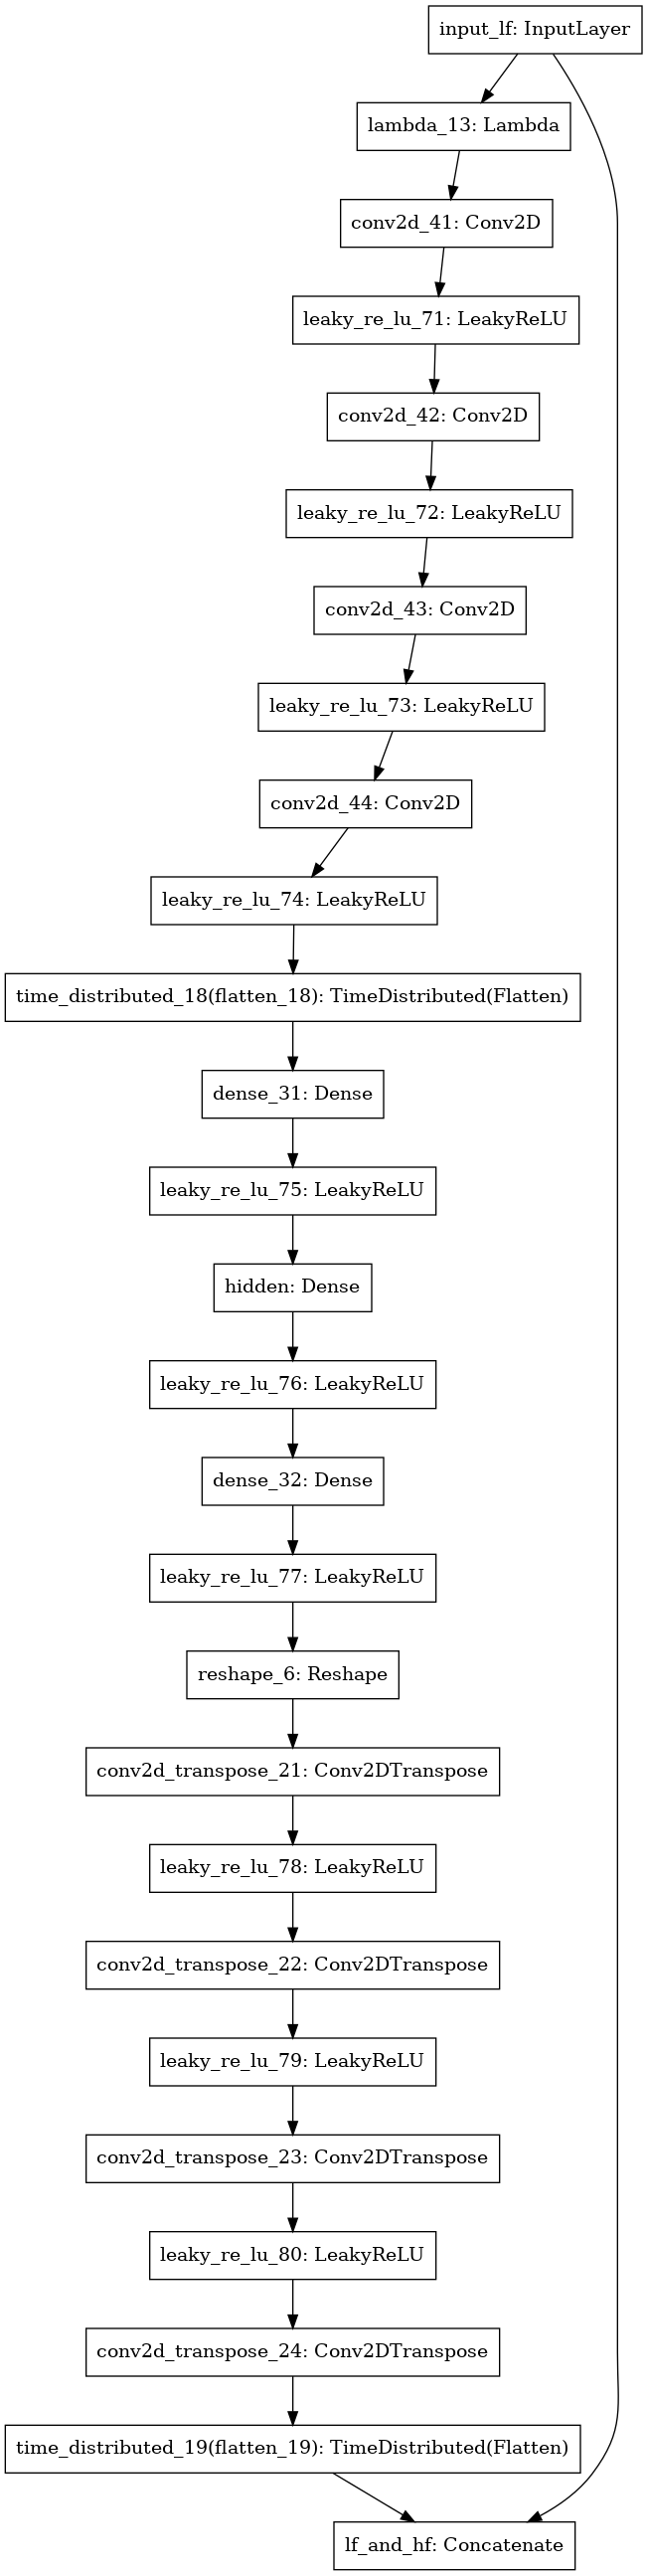

In [17]:
# baseline autoencoder

def mk_model():
    input_lower = Input((None, 129), name="input_lf")
    layer = Lambda(lambda x: K.expand_dims(x))(input_lower)
    layer = LeakyReLU(0.05)(Conv2D(16, kernel_size=(9,1), padding='same', activation='linear')(layer))
    layer = LeakyReLU(0.05)(Conv2D(20, kernel_size=(1,5), padding='same', activation='linear')(layer))
    layer = LeakyReLU(0.05)(Conv2D(24, kernel_size=(9,1), padding='same', activation='linear')(layer))
    layer = LeakyReLU(0.05)(Conv2D(28, kernel_size=(1,5), padding='same', activation='linear')(layer))
    layer = TimeDistributed(Flatten())(layer)
    layer = LeakyReLU(0.05)(Dense(1024)(layer))
    layer = LeakyReLU(0.05)(Dense(96, name='hidden')(layer))
    layer = LeakyReLU(0.05)(Dense(1024)(layer))
    layer = Reshape((-1, 128,8))(layer)
    layer = LeakyReLU(0.05)(Deconv2D(28, kernel_size=(1,5), padding='same', activation='linear')(layer))
    layer = LeakyReLU(0.05)(Deconv2D(24, kernel_size=(9,1), padding='same', activation='linear')(layer))
    layer = LeakyReLU(0.05)(Deconv2D(20, kernel_size=(1,5), padding='same', activation='linear')(layer))
    layer = Deconv2D(1, kernel_size=(9,1), padding='same', activation='linear')(layer)
    layer = TimeDistributed(Flatten())(layer)
    lf_and_hf = concatenate([input_lower, layer], name="lf_and_hf")
    mdl = Model(input_lower, lf_and_hf)
    mdl.summary()
    mdl.compile('adam', 'mse')
    return mdl

temp = tempfile.mktemp() + ".png"
mdl = mk_model()
model_callbacks.append(mk_model)
plot_model(mdl, to_file=temp)
Image(filename=temp)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_lf (InputLayer)           (None, None, 129)    0                                            
__________________________________________________________________________________________________
lambda_14 (Lambda)              (None, None, 129, 1) 0           input_lf[0][0]                   
__________________________________________________________________________________________________
conv2d_45 (Conv2D)              (None, None, 129, 16 160         lambda_14[0][0]                  
__________________________________________________________________________________________________
leaky_re_lu_81 (LeakyReLU)      (None, None, 129, 16 0           conv2d_45[0][0]                  
__________________________________________________________________________________________________
conv2d_46 

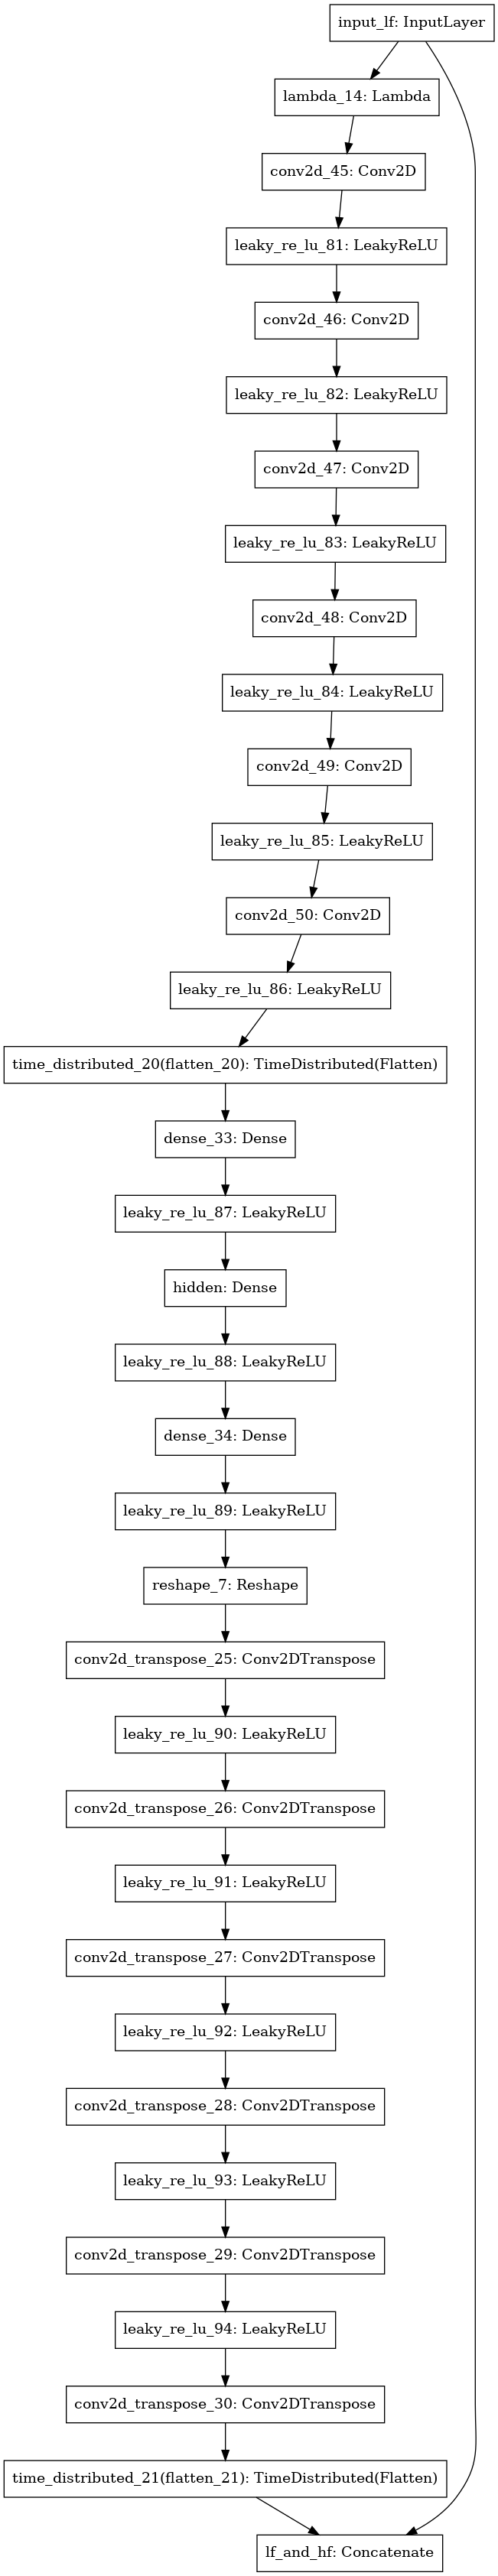

In [18]:
# baseline autoencoder - 3 encoding

def mk_model():
    input_lower = Input((None, 129), name="input_lf")
    layer = Lambda(lambda x: K.expand_dims(x))(input_lower)
    layer = LeakyReLU(0.05)(Conv2D(16, kernel_size=(9,1), padding='same', activation='linear')(layer))
    layer = LeakyReLU(0.05)(Conv2D(20, kernel_size=(1,5), padding='same', activation='linear')(layer))
    layer = LeakyReLU(0.05)(Conv2D(24, kernel_size=(9,1), padding='same', activation='linear')(layer))
    layer = LeakyReLU(0.05)(Conv2D(28, kernel_size=(1,5), padding='same', activation='linear')(layer))
    layer = LeakyReLU(0.05)(Conv2D(32, kernel_size=(9,1), padding='same', activation='linear')(layer))
    layer = LeakyReLU(0.05)(Conv2D(36, kernel_size=(1,5), padding='same', activation='linear')(layer))
    layer = TimeDistributed(Flatten())(layer)
    layer = LeakyReLU(0.05)(Dense(1024)(layer))
    layer = LeakyReLU(0.05)(Dense(96, name='hidden')(layer))
    layer = LeakyReLU(0.05)(Dense(1024)(layer))
    layer = Reshape((-1, 128,8))(layer)
    layer = LeakyReLU(0.05)(Deconv2D(36, kernel_size=(1,5), padding='same', activation='linear')(layer))
    layer = LeakyReLU(0.05)(Deconv2D(32, kernel_size=(9,1), padding='same', activation='linear')(layer))    
    layer = LeakyReLU(0.05)(Deconv2D(28, kernel_size=(1,5), padding='same', activation='linear')(layer))
    layer = LeakyReLU(0.05)(Deconv2D(24, kernel_size=(9,1), padding='same', activation='linear')(layer))
    layer = LeakyReLU(0.05)(Deconv2D(20, kernel_size=(1,5), padding='same', activation='linear')(layer))
    layer = Deconv2D(1, kernel_size=(9,1), padding='same', activation='linear')(layer)
    layer = TimeDistributed(Flatten())(layer)
    lf_and_hf = concatenate([input_lower, layer], name="lf_and_hf")
    mdl = Model(input_lower, lf_and_hf)
    mdl.summary()
    mdl.compile('adam', 'mse')
    return mdl

temp = tempfile.mktemp() + ".png"
mdl = mk_model()
model_callbacks.append(mk_model)
plot_model(mdl, to_file=temp)
Image(filename=temp)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_lf (InputLayer)           (None, None, 129)    0                                            
__________________________________________________________________________________________________
lambda_15 (Lambda)              (None, None, 129, 1) 0           input_lf[0][0]                   
__________________________________________________________________________________________________
conv2d_51 (Conv2D)              (None, None, 129, 16 160         lambda_15[0][0]                  
__________________________________________________________________________________________________
leaky_re_lu_95 (LeakyReLU)      (None, None, 129, 16 0           conv2d_51[0][0]                  
__________________________________________________________________________________________________
conv2d_52 

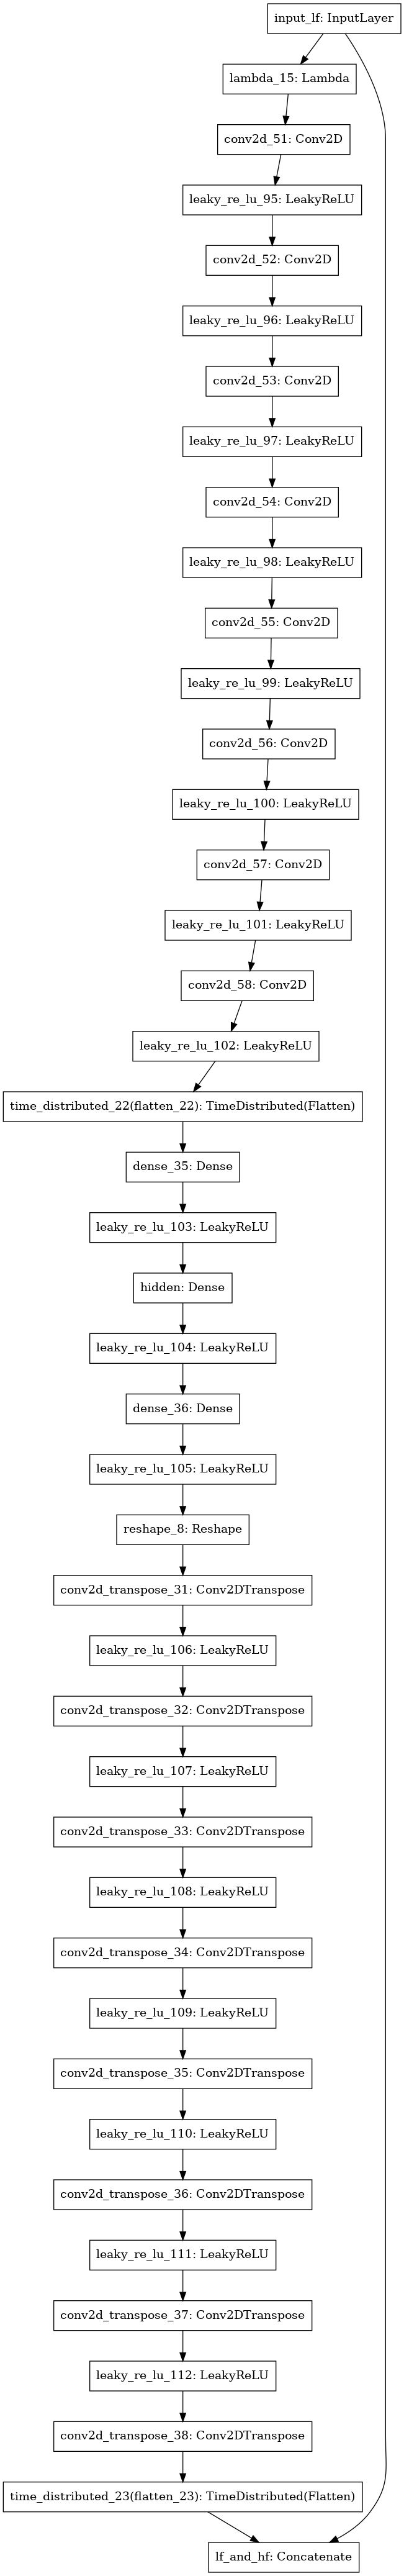

In [19]:
# baseline autoencoder - 4 encoding

def mk_model():
    input_lower = Input((None, 129), name="input_lf")
    layer = Lambda(lambda x: K.expand_dims(x))(input_lower)
    layer = LeakyReLU(0.05)(Conv2D(16, kernel_size=(9,1), padding='same', activation='linear')(layer))
    layer = LeakyReLU(0.05)(Conv2D(20, kernel_size=(1,5), padding='same', activation='linear')(layer))
    layer = LeakyReLU(0.05)(Conv2D(24, kernel_size=(9,1), padding='same', activation='linear')(layer))
    layer = LeakyReLU(0.05)(Conv2D(28, kernel_size=(1,5), padding='same', activation='linear')(layer))
    layer = LeakyReLU(0.05)(Conv2D(32, kernel_size=(9,1), padding='same', activation='linear')(layer))
    layer = LeakyReLU(0.05)(Conv2D(36, kernel_size=(1,5), padding='same', activation='linear')(layer))
    layer = LeakyReLU(0.05)(Conv2D(40, kernel_size=(9,1), padding='same', activation='linear')(layer))
    layer = LeakyReLU(0.05)(Conv2D(48, kernel_size=(1,5), padding='same', activation='linear')(layer))
    layer = TimeDistributed(Flatten())(layer)
    layer = LeakyReLU(0.05)(Dense(1024)(layer))
    layer = LeakyReLU(0.05)(Dense(96, name='hidden')(layer))
    layer = LeakyReLU(0.05)(Dense(1024)(layer))
    layer = Reshape((-1, 128,8))(layer)
    layer = LeakyReLU(0.05)(Deconv2D(48, kernel_size=(1,5), padding='same', activation='linear')(layer))
    layer = LeakyReLU(0.05)(Deconv2D(40, kernel_size=(9,1), padding='same', activation='linear')(layer))    
    layer = LeakyReLU(0.05)(Deconv2D(36, kernel_size=(1,5), padding='same', activation='linear')(layer))
    layer = LeakyReLU(0.05)(Deconv2D(32, kernel_size=(9,1), padding='same', activation='linear')(layer))    
    layer = LeakyReLU(0.05)(Deconv2D(28, kernel_size=(1,5), padding='same', activation='linear')(layer))
    layer = LeakyReLU(0.05)(Deconv2D(24, kernel_size=(9,1), padding='same', activation='linear')(layer))
    layer = LeakyReLU(0.05)(Deconv2D(20, kernel_size=(1,5), padding='same', activation='linear')(layer))
    layer = Deconv2D(1, kernel_size=(9,1), padding='same', activation='linear')(layer)
    layer = TimeDistributed(Flatten())(layer)
    lf_and_hf = concatenate([input_lower, layer], name="lf_and_hf")
    mdl = Model(input_lower, lf_and_hf)
    mdl.summary()
    mdl.compile('adam', 'mse')
    return mdl

temp = tempfile.mktemp() + ".png"
mdl = mk_model()
model_callbacks.append(mk_model)
plot_model(mdl, to_file=temp)
Image(filename=temp)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_lf (InputLayer)           (None, None, 129)    0                                            
__________________________________________________________________________________________________
lambda_16 (Lambda)              (None, None, 129, 1) 0           input_lf[0][0]                   
__________________________________________________________________________________________________
conv2d_59 (Conv2D)              (None, None, 129, 16 160         lambda_16[0][0]                  
__________________________________________________________________________________________________
leaky_re_lu_113 (LeakyReLU)     (None, None, 129, 16 0           conv2d_59[0][0]                  
__________________________________________________________________________________________________
conv2d_60 

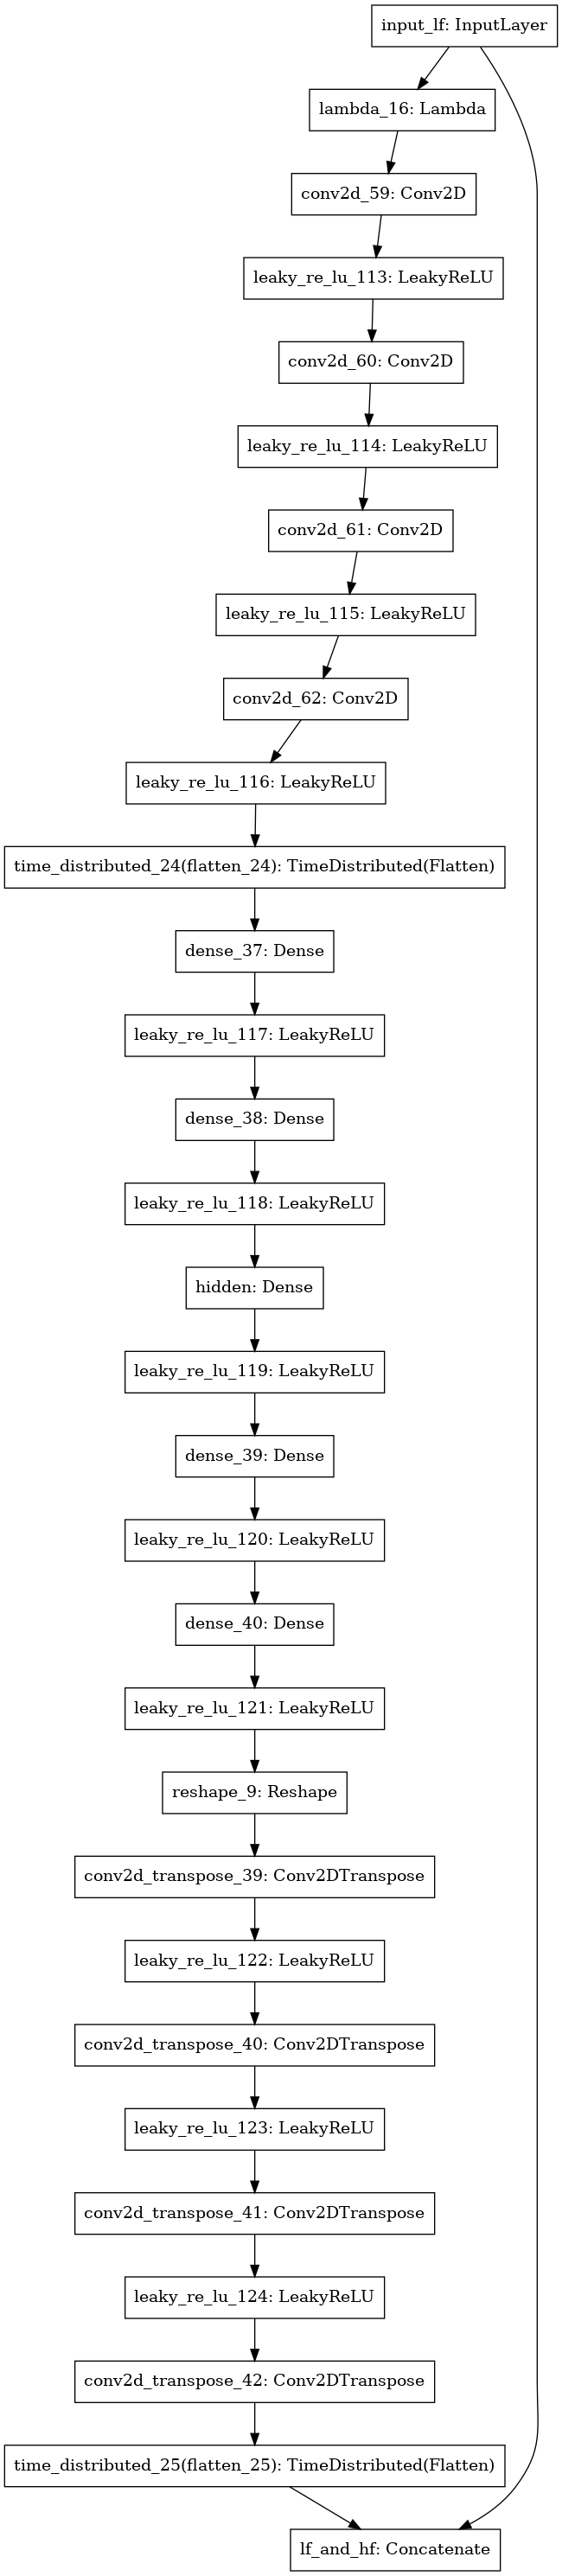

In [20]:
# baseline autoencoder - deeped mid representation - 2 layers

def mk_model():
    input_lower = Input((None, 129), name="input_lf")
    layer = Lambda(lambda x: K.expand_dims(x))(input_lower)
    layer = LeakyReLU(0.05)(Conv2D(16, kernel_size=(9,1), padding='same', activation='linear')(layer))
    layer = LeakyReLU(0.05)(Conv2D(20, kernel_size=(1,5), padding='same', activation='linear')(layer))
    layer = LeakyReLU(0.05)(Conv2D(24, kernel_size=(9,1), padding='same', activation='linear')(layer))
    layer = LeakyReLU(0.05)(Conv2D(28, kernel_size=(1,5), padding='same', activation='linear')(layer))
    layer = TimeDistributed(Flatten())(layer)
    layer = LeakyReLU(0.05)(Dense(1024)(layer))
    layer = LeakyReLU(0.05)(Dense(512)(layer))
    layer = LeakyReLU(0.05)(Dense(96, name='hidden')(layer))
    layer = LeakyReLU(0.05)(Dense(512)(layer))
    layer = LeakyReLU(0.05)(Dense(1024)(layer))
    layer = Reshape((-1, 128,8))(layer)
    layer = LeakyReLU(0.05)(Deconv2D(28, kernel_size=(1,5), padding='same', activation='linear')(layer))
    layer = LeakyReLU(0.05)(Deconv2D(24, kernel_size=(9,1), padding='same', activation='linear')(layer))
    layer = LeakyReLU(0.05)(Deconv2D(20, kernel_size=(1,5), padding='same', activation='linear')(layer))
    layer = Deconv2D(1, kernel_size=(9,1), padding='same', activation='linear')(layer)
    layer = TimeDistributed(Flatten())(layer)
    lf_and_hf = concatenate([input_lower, layer], name="lf_and_hf")
    mdl = Model(input_lower, lf_and_hf)
    mdl.summary()
    mdl.compile('adam', 'mse')
    return mdl

temp = tempfile.mktemp() + ".png"
mdl = mk_model()
model_callbacks.append(mk_model)
plot_model(mdl, to_file=temp)
Image(filename=temp)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_lf (InputLayer)           (None, None, 129)    0                                            
__________________________________________________________________________________________________
lambda_17 (Lambda)              (None, None, 129, 1) 0           input_lf[0][0]                   
__________________________________________________________________________________________________
conv2d_63 (Conv2D)              (None, None, 129, 16 160         lambda_17[0][0]                  
__________________________________________________________________________________________________
leaky_re_lu_125 (LeakyReLU)     (None, None, 129, 16 0           conv2d_63[0][0]                  
__________________________________________________________________________________________________
conv2d_64 

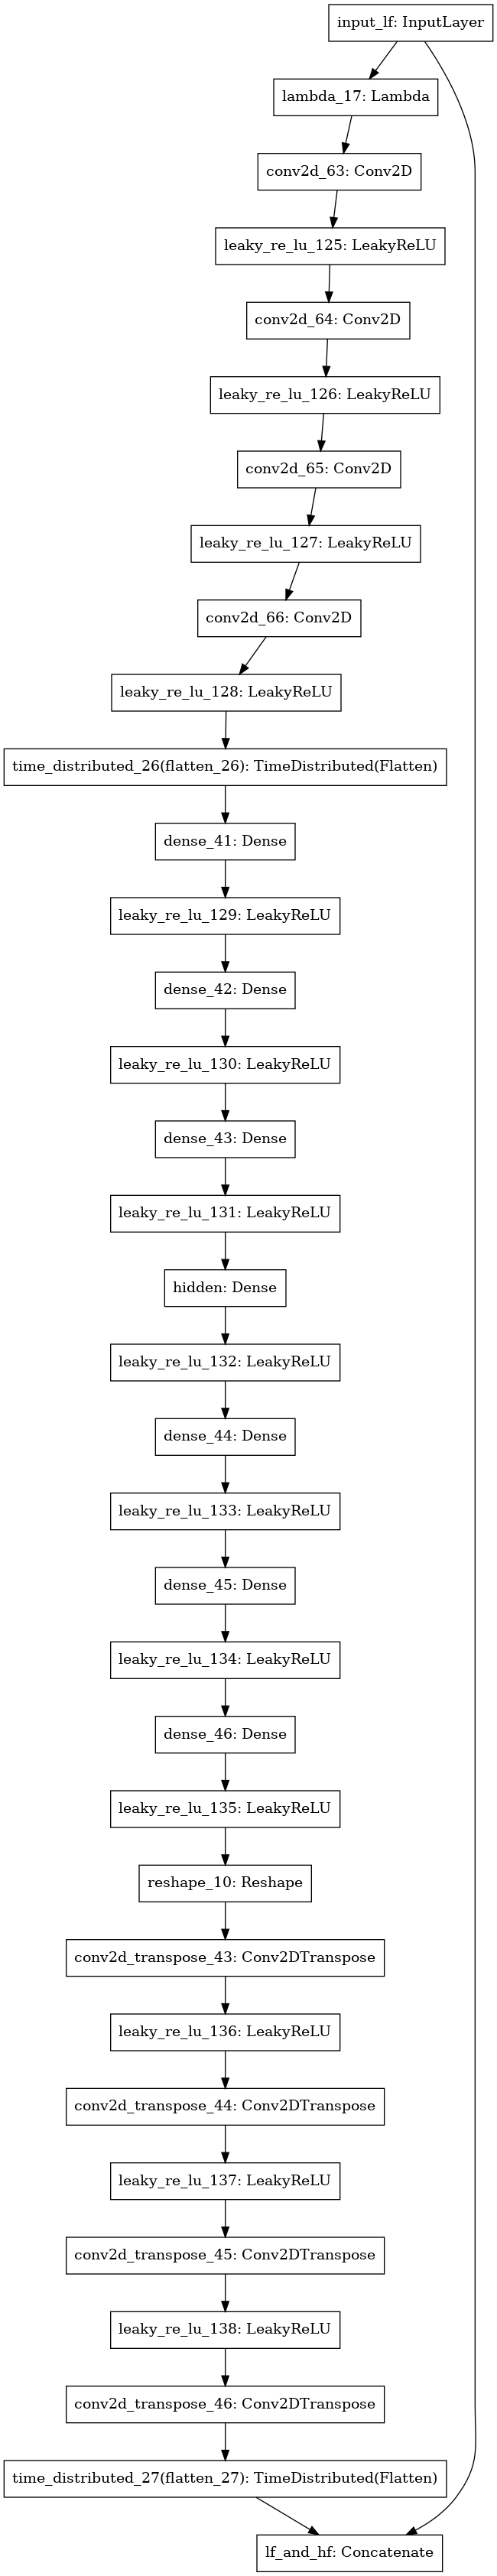

In [21]:
# baseline autoencoder - deeped mid representation - 3 layers

def mk_model():
    input_lower = Input((None, 129), name="input_lf")
    layer = Lambda(lambda x: K.expand_dims(x))(input_lower)
    layer = LeakyReLU(0.05)(Conv2D(16, kernel_size=(9,1), padding='same', activation='linear')(layer))
    layer = LeakyReLU(0.05)(Conv2D(20, kernel_size=(1,5), padding='same', activation='linear')(layer))
    layer = LeakyReLU(0.05)(Conv2D(24, kernel_size=(9,1), padding='same', activation='linear')(layer))
    layer = LeakyReLU(0.05)(Conv2D(28, kernel_size=(1,5), padding='same', activation='linear')(layer))
    layer = TimeDistributed(Flatten())(layer)
    layer = LeakyReLU(0.05)(Dense(1024)(layer))
    layer = LeakyReLU(0.05)(Dense(512)(layer))
    layer = LeakyReLU(0.05)(Dense(256)(layer))
    layer = LeakyReLU(0.05)(Dense(96, name='hidden')(layer))
    layer = LeakyReLU(0.05)(Dense(256)(layer))
    layer = LeakyReLU(0.05)(Dense(512)(layer))
    layer = LeakyReLU(0.05)(Dense(1024)(layer))
    layer = Reshape((-1, 128,8))(layer)
    layer = LeakyReLU(0.05)(Deconv2D(28, kernel_size=(1,5), padding='same', activation='linear')(layer))
    layer = LeakyReLU(0.05)(Deconv2D(24, kernel_size=(9,1), padding='same', activation='linear')(layer))
    layer = LeakyReLU(0.05)(Deconv2D(20, kernel_size=(1,5), padding='same', activation='linear')(layer))
    layer = Deconv2D(1, kernel_size=(9,1), padding='same', activation='linear')(layer)
    layer = TimeDistributed(Flatten())(layer)
    lf_and_hf = concatenate([input_lower, layer], name="lf_and_hf")
    mdl = Model(input_lower, lf_and_hf)
    mdl.summary()
    mdl.compile('adam', 'mse')
    return mdl

temp = tempfile.mktemp() + ".png"
mdl = mk_model()
model_callbacks.append(mk_model)
plot_model(mdl, to_file=temp)
Image(filename=temp)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_lf (InputLayer)           (None, None, 129)    0                                            
__________________________________________________________________________________________________
lambda_18 (Lambda)              (None, None, 129, 1) 0           input_lf[0][0]                   
__________________________________________________________________________________________________
conv2d_67 (Conv2D)              (None, None, 129, 16 160         lambda_18[0][0]                  
__________________________________________________________________________________________________
leaky_re_lu_139 (LeakyReLU)     (None, None, 129, 16 0           conv2d_67[0][0]                  
__________________________________________________________________________________________________
conv2d_68 

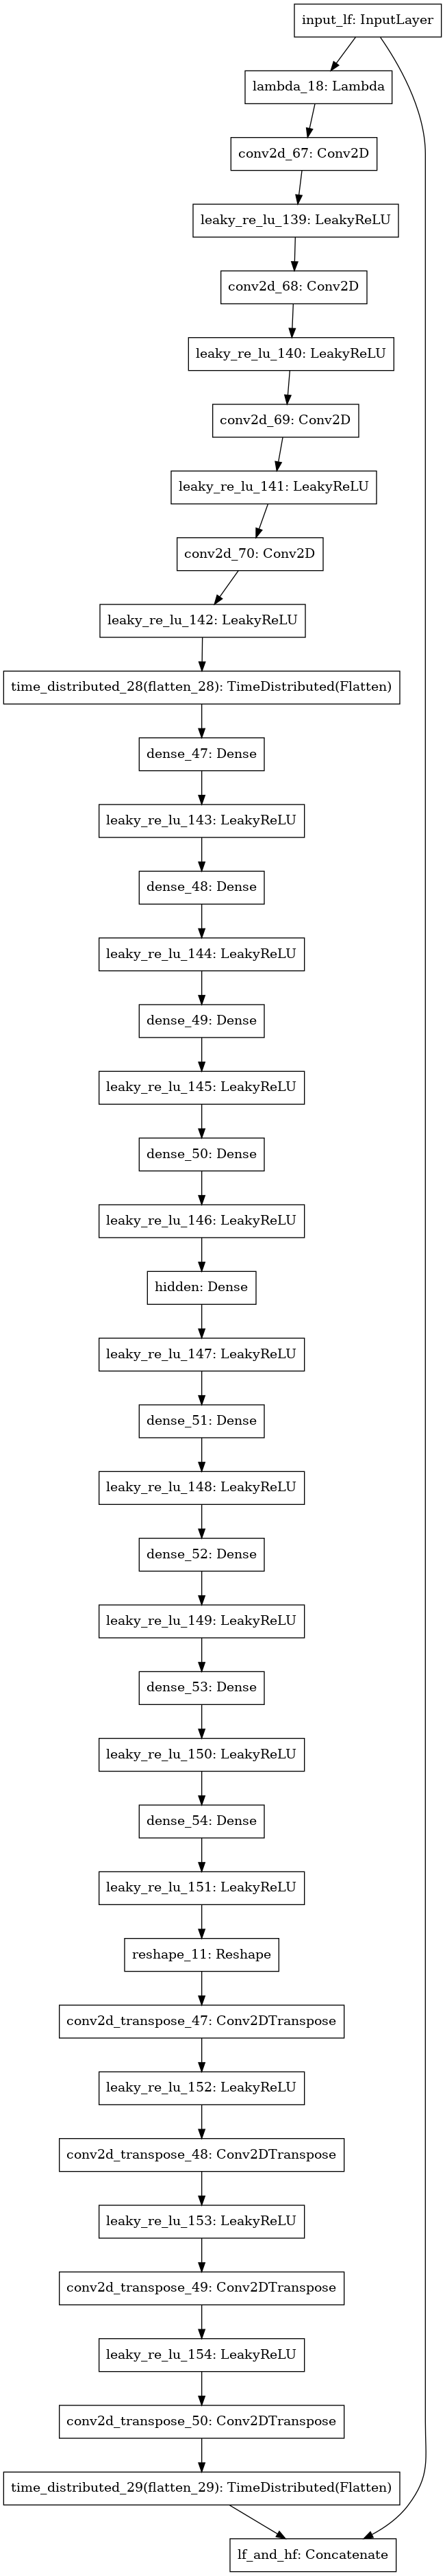

In [22]:
# baseline autoencoder - deeped mid representation - 4 layers

def mk_model():
    input_lower = Input((None, 129), name="input_lf")
    layer = Lambda(lambda x: K.expand_dims(x))(input_lower)
    layer = LeakyReLU(0.05)(Conv2D(16, kernel_size=(9,1), padding='same', activation='linear')(layer))
    layer = LeakyReLU(0.05)(Conv2D(20, kernel_size=(1,5), padding='same', activation='linear')(layer))
    layer = LeakyReLU(0.05)(Conv2D(24, kernel_size=(9,1), padding='same', activation='linear')(layer))
    layer = LeakyReLU(0.05)(Conv2D(28, kernel_size=(1,5), padding='same', activation='linear')(layer))
    layer = TimeDistributed(Flatten())(layer)
    layer = LeakyReLU(0.05)(Dense(1024)(layer))
    layer = LeakyReLU(0.05)(Dense(512)(layer))
    layer = LeakyReLU(0.05)(Dense(256)(layer))
    layer = LeakyReLU(0.05)(Dense(192)(layer))
    layer = LeakyReLU(0.05)(Dense(96, name='hidden')(layer))
    layer = LeakyReLU(0.05)(Dense(192)(layer))
    layer = LeakyReLU(0.05)(Dense(256)(layer))
    layer = LeakyReLU(0.05)(Dense(512)(layer))
    layer = LeakyReLU(0.05)(Dense(1024)(layer))
    layer = Reshape((-1, 128,8))(layer)
    layer = LeakyReLU(0.05)(Deconv2D(28, kernel_size=(1,5), padding='same', activation='linear')(layer))
    layer = LeakyReLU(0.05)(Deconv2D(24, kernel_size=(9,1), padding='same', activation='linear')(layer))
    layer = LeakyReLU(0.05)(Deconv2D(20, kernel_size=(1,5), padding='same', activation='linear')(layer))
    layer = Deconv2D(1, kernel_size=(9,1), padding='same', activation='linear')(layer)
    layer = TimeDistributed(Flatten())(layer)
    lf_and_hf = concatenate([input_lower, layer], name="lf_and_hf")
    mdl = Model(input_lower, lf_and_hf)
    mdl.summary()
    mdl.compile('adam', 'mse')
    return mdl

temp = tempfile.mktemp() + ".png"
mdl = mk_model()
model_callbacks.append(mk_model)
plot_model(mdl, to_file=temp)
Image(filename=temp)

##### Data loading

In [4]:
TRAIN = 4500
VALID = 80
TEST = 80

import numpy as np
import scipy.io.wavfile as sio
import gc

import tempfile
import subprocess

tempnam = tempfile.mktemp

log_fft_source = log_fft_target = phase = train = test = valid = experiment = None
gc.collect()

dataset = Dataset.from_folder("DAE-libri",
                              verbose = False,
                              dataset_pad = 8,
                              trim_lengths = 160000,
                              cache = "cache",
                              ram_cache_size = None,
                              filter=lambda x:x.endswith(".wav") and not x.endswith(".gsm.wav"))


log_fft_source = np.zeros([TRAIN + VALID + TEST, 1248, 129], np.float32)
log_fft_target = np.zeros([TRAIN + VALID + TEST, 1248, 257], np.float32)
phase = np.zeros([TEST, 1248, 129], np.float32)

for ix, file in enumerate(dataset.files[:TRAIN + VALID + TEST]):
    print(ix)
    data = sio.read(dataset.root + "/" + file)[1] # .astype(np.float32) to generate noise in the experiment...
    oldname = tempnam() + '.oldwav'
    sio.write(oldname, 16000, data)
    tmpname = tempnam() + '.gsm'
    newname = dataset.root + "/" + file + ".gsm.wav"
    subprocess.Popen(['sox', oldname, '-r', '8000', tmpname]).communicate()
    subprocess.Popen(['sox', tmpname, '-r', '16000', "-e", "signed", '-b', '16',  newname]).communicate()
    list(map(os.remove, [oldname, tmpname]))


window = np.hamming(512)
for ix, file in enumerate(dataset.files[:TRAIN + VALID + TEST]):
    print(ix)
    r = sio.read(dataset.root + "/" + file)[1].astype(np.float32)
    r /= 2**15
    for time in range(1248):
        win = r[128 * time : 128 * time + 512]
        if len(win) != 512:
            break
        fft = np.fft.rfft(window * win) / 512
        log_fft_target[ix, time, :] = -np.log(np.abs(fft) ** 2 + 2e-12)
    r = sio.read(dataset.root + "/" + file + ".gsm.wav")[1].astype(np.float32)
    r /= 2**15
    for time in range(1248):
        win = r[128 * time : 128 * time + 512]
        if len(win) != 512:
            break
        fft = np.fft.rfft(window * win) / 512
        log_fft_source[ix, time, :] = -np.log(np.abs(fft) ** 2 + 2e-12)[:129]
        if ix >= TRAIN+VALID:
            phase[ix - TRAIN - VALID, time, :] = np.angle(fft)[:129]


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1861
1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060


3501
3502
3503
3504
3505
3506
3507
3508
3509
3510
3511
3512
3513
3514
3515
3516
3517
3518
3519
3520
3521
3522
3523
3524
3525
3526
3527
3528
3529
3530
3531
3532
3533
3534
3535
3536
3537
3538
3539
3540
3541
3542
3543
3544
3545
3546
3547
3548
3549
3550
3551
3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699
3700


629
630
631
632
633
634
635
636
637
638
639
640
641
642
643
644
645
646
647
648
649
650
651
652
653
654
655
656
657
658
659
660
661
662
663
664
665
666
667
668
669
670
671
672
673
674
675
676
677
678
679
680
681
682
683
684
685
686
687
688
689
690
691
692
693
694
695
696
697
698
699
700
701
702
703
704
705
706
707
708
709
710
711
712
713
714
715
716
717
718
719
720
721
722
723
724
725
726
727
728
729
730
731
732
733
734
735
736
737
738
739
740
741
742
743
744
745
746
747
748
749
750
751
752
753
754
755
756
757
758
759
760
761
762
763
764
765
766
767
768
769
770
771
772
773
774
775
776
777
778
779
780
781
782
783
784
785
786
787
788
789
790
791
792
793
794
795
796
797
798
799
800
801
802
803
804
805
806
807
808
809
810
811
812
813
814
815
816
817
818
819
820
821
822
823
824
825
826
827
828
829
830
831
832
833
834
835
836
837
838
839
840
841
842
843
844
845
846
847
848
849
850
851
852
853
854
855
856
857
858
859
860
861
862
863
864
865
866
867
868
869
870
871
872
873
874
875
876
877
878


2343
2344
2345
2346
2347
2348
2349
2350
2351
2352
2353
2354
2355
2356
2357
2358
2359
2360
2361
2362
2363
2364
2365
2366
2367
2368
2369
2370
2371
2372
2373
2374
2375
2376
2377
2378
2379
2380
2381
2382
2383
2384
2385
2386
2387
2388
2389
2390
2391
2392
2393
2394
2395
2396
2397
2398
2399
2400
2401
2402
2403
2404
2405
2406
2407
2408
2409
2410
2411
2412
2413
2414
2415
2416
2417
2418
2419
2420
2421
2422
2423
2424
2425
2426
2427
2428
2429
2430
2431
2432
2433
2434
2435
2436
2437
2438
2439
2440
2441
2442
2443
2444
2445
2446
2447
2448
2449
2450
2451
2452
2453
2454
2455
2456
2457
2458
2459
2460
2461
2462
2463
2464
2465
2466
2467
2468
2469
2470
2471
2472
2473
2474
2475
2476
2477
2478
2479
2480
2481
2482
2483
2484
2485
2486
2487
2488
2489
2490
2491
2492
2493
2494
2495
2496
2497
2498
2499
2500
2501
2502
2503
2504
2505
2506
2507
2508
2509
2510
2511
2512
2513
2514
2515
2516
2517
2518
2519
2520
2521
2522
2523
2524
2525
2526
2527
2528
2529
2530
2531
2532
2533
2534
2535
2536
2537
2538
2539
2540
2541
2542


3982
3983
3984
3985
3986
3987
3988
3989
3990
3991
3992
3993
3994
3995
3996
3997
3998
3999
4000
4001
4002
4003
4004
4005
4006
4007
4008
4009
4010
4011
4012
4013
4014
4015
4016
4017
4018
4019
4020
4021
4022
4023
4024
4025
4026
4027
4028
4029
4030
4031
4032
4033
4034
4035
4036
4037
4038
4039
4040
4041
4042
4043
4044
4045
4046
4047
4048
4049
4050
4051
4052
4053
4054
4055
4056
4057
4058
4059
4060
4061
4062
4063
4064
4065
4066
4067
4068
4069
4070
4071
4072
4073
4074
4075
4076
4077
4078
4079
4080
4081
4082
4083
4084
4085
4086
4087
4088
4089
4090
4091
4092
4093
4094
4095
4096
4097
4098
4099
4100
4101
4102
4103
4104
4105
4106
4107
4108
4109
4110
4111
4112
4113
4114
4115
4116
4117
4118
4119
4120
4121
4122
4123
4124
4125
4126
4127
4128
4129
4130
4131
4132
4133
4134
4135
4136
4137
4138
4139
4140
4141
4142
4143
4144
4145
4146
4147
4148
4149
4150
4151
4152
4153
4154
4155
4156
4157
4158
4159
4160
4161
4162
4163
4164
4165
4166
4167
4168
4169
4170
4171
4172
4173
4174
4175
4176
4177
4178
4179
4180
4181


In [6]:
MEAN = 0 # min([log_fft_source.min(), log_fft_target.min()])
mean = log_fft_source.mean()
#log_fft_source -= MEAN
#log_fft_target -= MEAN
STD = []
for i in range(log_fft_source.shape[0]):
    rec = (log_fft_source[i] - mean) ** 2
    STD.append(rec.mean())
STD = np.sqrt(np.array(STD).mean())
log_fft_source /= STD
log_fft_target /= STD
print(log_fft_source.min(), log_fft_source.max())

0.0 4.3192935


In [7]:
train = log_fft_source[:TRAIN,:,:129], log_fft_target[:TRAIN]
valid = log_fft_source[TRAIN:TRAIN+VALID,:,:129], log_fft_target[TRAIN:TRAIN+VALID]
test = log_fft_source[TRAIN+VALID:TRAIN+VALID+TEST,:,:129], log_fft_target[TRAIN+VALID:TRAIN+VALID+TEST]

##### Training

In [ ]:
"""
To experiment add:
    printing experiment name
    saving progress to make it probeable
    callbacks of convergence
"""

class StopOnConvergence(Callback):
    """Callback that terminates training when a NaN loss is encountered.
    """

    def __init__(self, max_repetitions=10):
        super().__init__()
        self.max_repetitions = max_repetitions
    
    def on_train_begin(self, logs=None):
        self.repetitions = 0
        self.last_loss = np.inf
    
    def on_epoch_end(self, batch, logs=None):
        logs = logs or {}
        loss = logs.get('val_loss')
        if loss is not None:
            if loss > self.last_loss:
                self.repetitions += 1
            else:
                self.last_loss = loss
                self.repetitions = 0
            if self.repetitions > self.max_repetitions:
                self.model.stop_training = True


experiment_names = []

# assert that all models have a layer with hidden representation
for mk_model in model_callbacks:
    mdl = mk_model()
    assert len([x.name for x in mdl.layers if x.name == "hidden"]) == 1

for mk_model in model_callbacks:
    experiment = SingleExperiment(mk_model, train = train, valid = valid, test = test, run_parameters={"batch_size": 8})
    experiment.add_schedule(Schedule([0.001, 0.0001, 0.00001], [100, 100, 100], lambda rate: keras.optimizers.Adam(rate, clipvalue = 1.)))
    experiment.add_measure(MSE(), name='mse')
    experiment.add_callback(StopOnConvergence(4))
    experiment.run()
    experiment_names.append(experiment.name)
    experiment.report()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_lf (InputLayer)           (None, None, 129)    0                                            
__________________________________________________________________________________________________
lambda_29 (Lambda)              (None, None, 129, 1) 0           input_lf[0][0]                   
__________________________________________________________________________________________________
conv2d_115 (Conv2D)             (None, None, 129, 16 160         lambda_29[0][0]                  
__________________________________________________________________________________________________
leaky_re_lu_261 (LeakyReLU)     (None, None, 129, 16 0           conv2d_115[0][0]                 
__________________________________________________________________________________________________
conv2d_116

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_lf (InputLayer)           (None, None, 129)    0                                            
__________________________________________________________________________________________________
lambda_32 (Lambda)              (None, None, 129, 1) 0           input_lf[0][0]                   
__________________________________________________________________________________________________
conv2d_125 (Conv2D)             (None, None, 129, 16 160         lambda_32[0][0]                  
__________________________________________________________________________________________________
leaky_re_lu_277 (LeakyReLU)     (None, None, 129, 16 0           conv2d_125[0][0]                 
__________________________________________________________________________________________________
conv2d_126

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_lf (InputLayer)           (None, None, 129)    0                                            
__________________________________________________________________________________________________
lambda_34 (Lambda)              (None, None, 129, 1) 0           input_lf[0][0]                   
__________________________________________________________________________________________________
conv2d_135 (Conv2D)             (None, None, 129, 16 160         lambda_34[0][0]                  
__________________________________________________________________________________________________
leaky_re_lu_301 (LeakyReLU)     (None, None, 129, 16 0           conv2d_135[0][0]                 
__________________________________________________________________________________________________
conv2d_136

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_lf (InputLayer)           (None, None, 129)    0                                            
__________________________________________________________________________________________________
lambda_35 (Lambda)              (None, None, 129, 1) 0           input_lf[0][0]                   
__________________________________________________________________________________________________
conv2d_143 (Conv2D)             (None, None, 129, 16 160         lambda_35[0][0]                  
__________________________________________________________________________________________________
leaky_re_lu_319 (LeakyReLU)     (None, None, 129, 16 0           conv2d_143[0][0]                 
__________________________________________________________________________________________________
conv2d_144

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_lf (InputLayer)           (None, None, 129)    0                                            
__________________________________________________________________________________________________
lambda_37 (Lambda)              (None, None, 129, 1) 0           input_lf[0][0]                   
__________________________________________________________________________________________________
conv2d_151 (Conv2D)             (None, None, 129, 16 160         lambda_37[0][0]                  
__________________________________________________________________________________________________
leaky_re_lu_345 (LeakyReLU)     (None, None, 129, 16 0           conv2d_151[0][0]                 
__________________________________________________________________________________________________
conv2d_152

Train on 160 samples, validate on 8 samples
Epoch 1/100
160/160 [==============================] - 69s 430ms/step - loss: 0.8637 - val_loss: 0.1676
Epoch 2/100
160/160 [==============================] - 66s 414ms/step - loss: 0.1464 - val_loss: 0.1252
Epoch 3/100
160/160 [==============================] - 66s 414ms/step - loss: 0.1175 - val_loss: 0.1159
Epoch 4/100
160/160 [==============================] - 66s 414ms/step - loss: 0.1076 - val_loss: 0.1051
Epoch 5/100
160/160 [==============================] - 66s 414ms/step - loss: 0.1013 - val_loss: 0.1140
Epoch 6/100
160/160 [==============================] - 66s 415ms/step - loss: 0.1051 - val_loss: 0.0999
Epoch 7/100
160/160 [==============================] - 66s 413ms/step - loss: 0.1074 - val_loss: 0.1238
Epoch 8/100
160/160 [==============================] - 66s 413ms/step - loss: 0.1021 - val_loss: 0.1260
Epoch 9/100
160/160 [==============================] - 66s 413ms/step - loss: 0.1024 - val_loss: 0.0982
Epoch 10/100
160/160

Process ForkPoolWorker-24:
Process ForkPoolWorker-23:
Process ForkPoolWorker-20:
Process ForkPoolWorker-25:
Process ForkPoolWorker-19:
Process ForkPoolWorker-18:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.6/site-packages/multiprocess/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/site-packages/multiprocess/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/site-packages/multiprocess/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/site-packages/multiprocess/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/site-packages/multiprocess/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/site-packages/multiprocess/process.py", line 93, in run
    self._targe

  File "/usr/lib/python3.6/site-packages/multiprocess/synchronize.py", line 102, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt
KeyboardInterrupt
Process ForkPoolWorker-30:
KeyboardInterrupt
Traceback (most recent call last):
  File "/usr/lib/python3.6/site-packages/multiprocess/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/site-packages/multiprocess/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/site-packages/multiprocess/pool.py", line 108, in worker
    task = get()


KeyboardInterrupt: 

  File "/usr/lib/python3.6/site-packages/multiprocess/queues.py", line 345, in get
    with self._rlock:
  File "/usr/lib/python3.6/site-packages/multiprocess/synchronize.py", line 102, in __enter__
    return self._semlock.__enter__()
Process ForkPoolWorker-29:
Traceback (most recent call last):
Process ForkPoolWorker-28:
  File "/usr/lib/python3.6/site-packages/multiprocess/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/site-packages/multiprocess/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/site-packages/multiprocess/pool.py", line 108, in worker
    task = get()
  File "/usr/lib/python3.6/site-packages/multiprocess/queues.py", line 345, in get
    with self._rlock:
Traceback (most recent call last):
  File "/usr/lib/python3.6/site-packages/multiprocess/synchronize.py", line 102, in __enter__
    return self._semlock.__enter__()
  File "/usr/lib/python3.6/site-packages/multiprocess/process.py", l

./runs/1538486124.7651565


In [5]:
with open("/tmp/test_data.bin", "wb") as f:
    pickle.dump(test, f)
    
with open("/tmp/data_norm.bin", "wb") as f:
    pickle.dump((MEAN, STD), f)

NameError: name 'MEAN' is not defined

In [ ]:
experiment_names

### After reset

##### Load models and data

In [41]:
# import from first cell after restarting kernel

experiment_names = ['./runs/1537782147.4425058', './runs/1537782148.8507273', "./runs/1536919946.9646845"]

In [42]:
with open("/tmp/test_data.bin", "rb") as f:
    test, phase = pickle.load(f)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_lf (InputLayer)           (None, None, 129)    0                                            
__________________________________________________________________________________________________
conv1d_43 (Conv1D)              (None, None, 1024)   1189888     input_lf[0][0]                   
__________________________________________________________________________________________________
hidden (Conv1D)                 (None, None, 256)    2359552     conv1d_43[0][0]                  
__________________________________________________________________________________________________
dense_45 (Dense)                (None, None, 1024)   263168      hidden[0][0]                     
__________________________________________________________________________________________________
dense_46 (

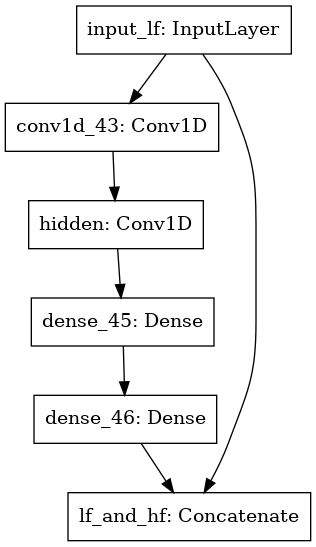

OSError: Unable to open file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable')

In [20]:
models = []

for model in experiment_names:
    mdl = Estimator.only_model(model)
    mdl.summary()
    print("-----\n" + model)
    models.append(mdl)
    try:
        temp = tempfile.mktemp() + ".png"
        plot_model(mdl, to_file=temp)
        display(Image(filename=temp))
    except:
        pass

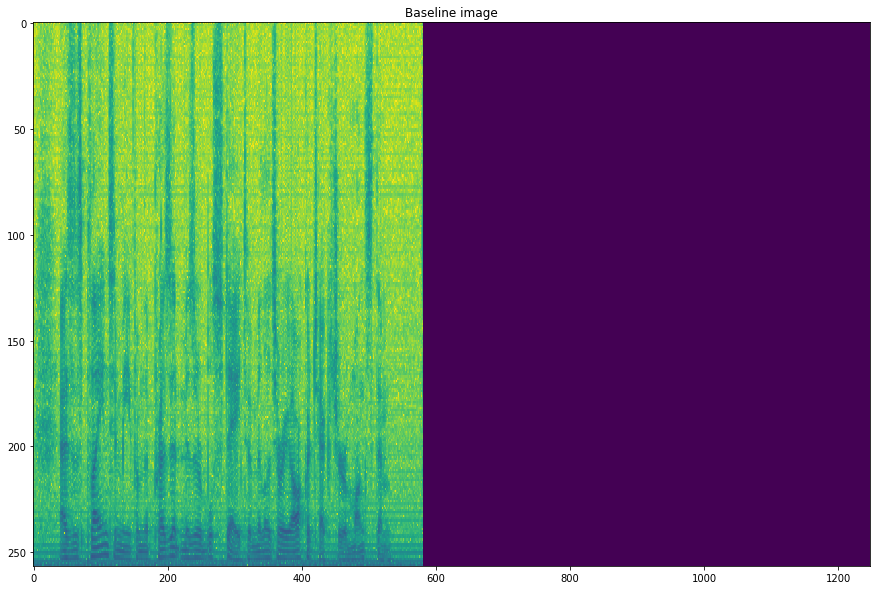

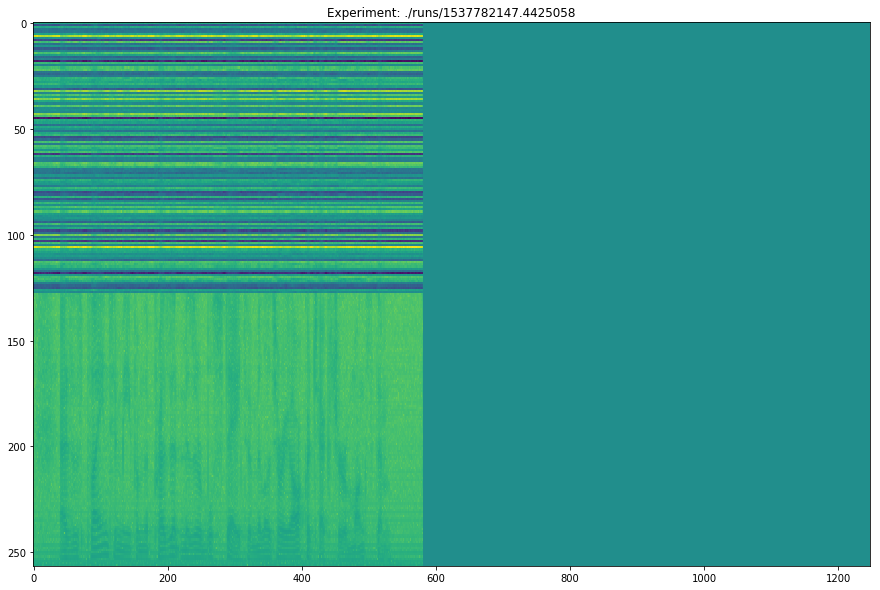

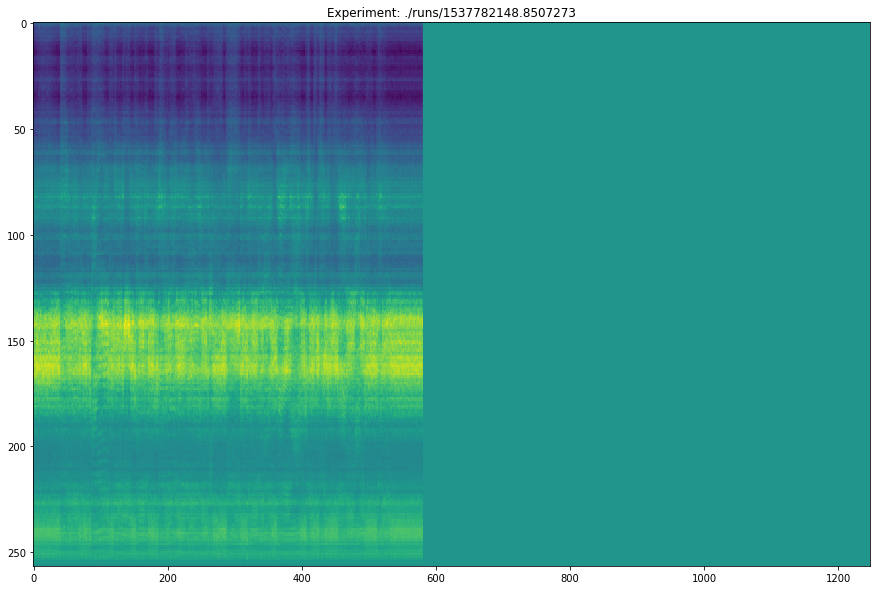

In [46]:
# visualisation

image, gt = test

plt.figure(figsize=(15,10))
plt.title("Baseline image")
plt.imshow(np.rot90(gt[0, :, :]), aspect='auto')
plt.show()

for name, mdl in zip(experiment_names, models):
    prediction = mdl.predict(image[:1])
    plt.figure(figsize=(15,10))
    plt.title("Experiment: " + name)
    plt.imshow(np.rot90(prediction[0, :, :]), aspect='auto')
    plt.show()

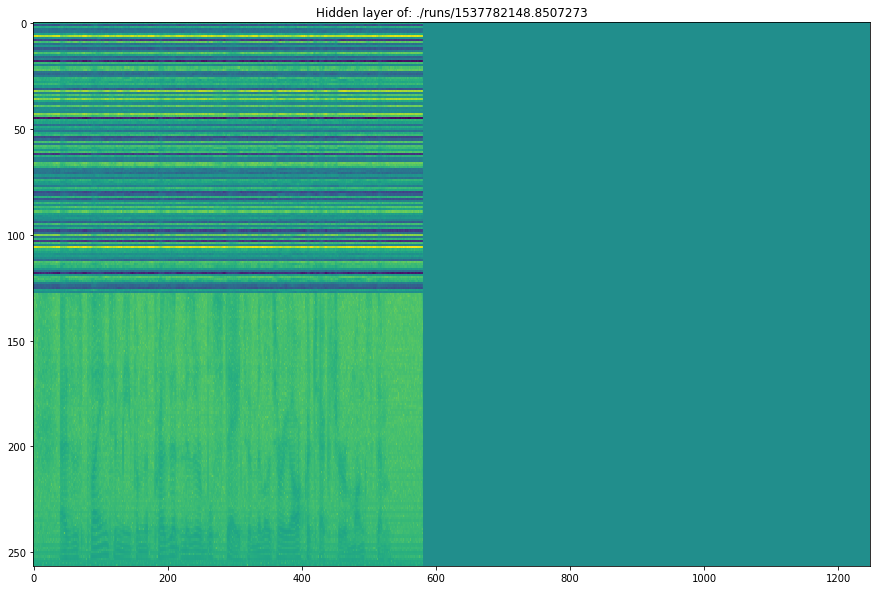

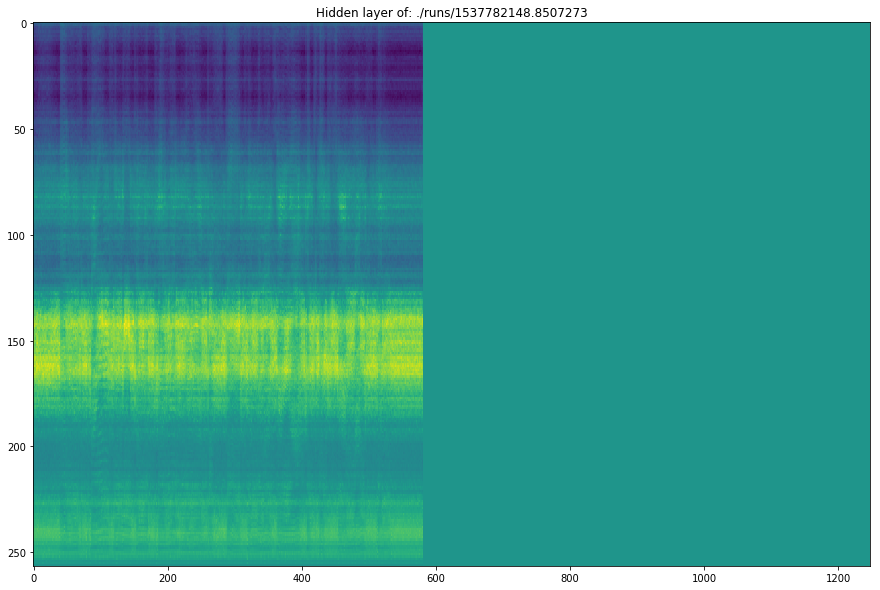

In [47]:
# hidden representation of each model - verify variability

image, gt = test

for name, mdl in zip(experiment_names, models):
    model = (mdl.input, [x.output for x in mdl.layers if x.name == "hidden"][0])
    prediction = mdl.predict(image[:1])
    plt.figure(figsize=(15,10))
    plt.title("Hidden layer of: " + experiment.name)
    plt.imshow(np.rot90(prediction[0, :, :]), aspect='auto')
    plt.show()

Groundtruth signal


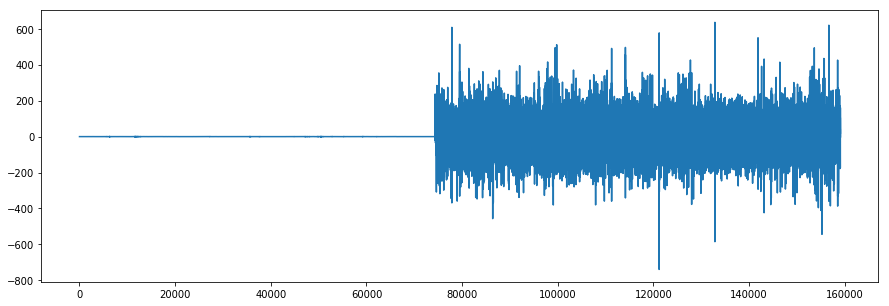

Input signal


/usr/lib/python3.6/site-packages/ipykernel_launcher.py:18: ComplexWarning: Casting complex values to real discards the imaginary part


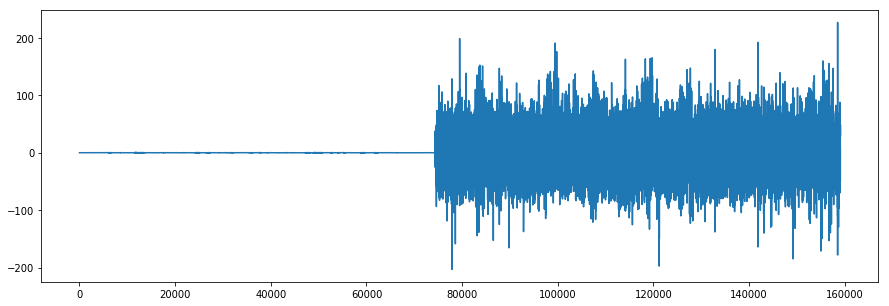

Prediction of ./runs/1537782147.4425058


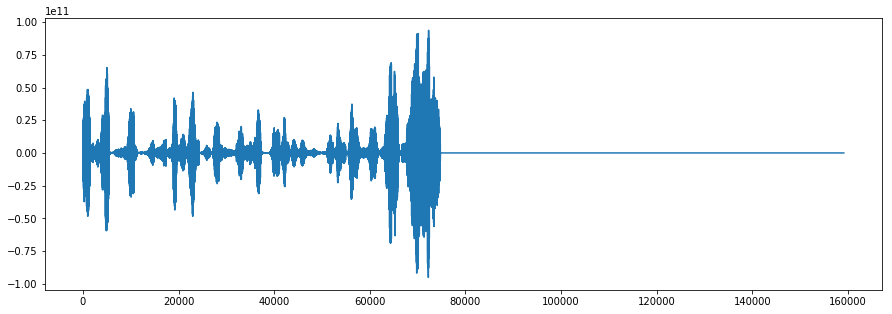

Prediction of ./runs/1537782148.8507273


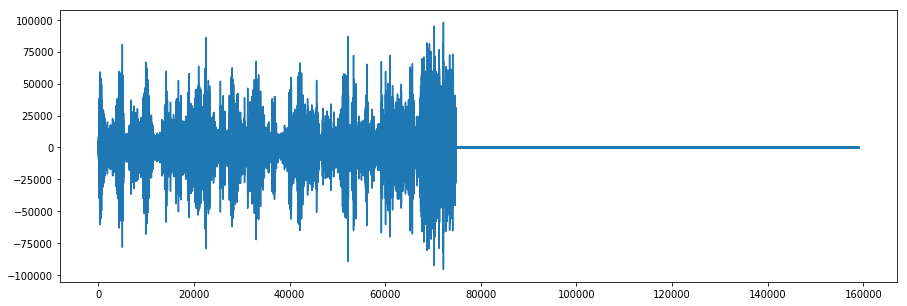

In [51]:
# predicted spectrograms

print("Groundtruth signal")
sound = gt[0]
spec = (np.sqrt(np.exp(-sound)) * 512) * np.exp(phase[0, :, :] * 1j)
sound = np.zeros(spec.shape[0] * 128 + 512 - 128)
for i in range(spec.shape[0]):
    frame = np.fft.irfft(spec[i,:])
    sound[128 * i : 128 * i + 512] += frame
plt.figure(figsize=(15,5))
plt.plot(sound[:-1024])
plt.show()
display(Audio(sound[:-1024], rate=16000))

print("Input signal")
sound = image[0]
spec = gt[0] * 0
spec[:,:129] = (np.sqrt(np.exp(-sound)) * 512) * np.exp(phase[0, :, :129] * 1j)
sound = np.zeros(spec.shape[0] * 128 + 512 - 128)
for i in range(spec.shape[0]):
    frame = np.fft.irfft(spec[i,:])
    sound[128 * i : 128 * i + 512] += frame
plt.figure(figsize=(15,5))
plt.plot(sound[:-1024])
plt.show()
display(Audio(sound[:-1024], rate=16000))


for name, mdl in zip(experiment_names, models):
    print("Prediction of " + name)
    spec = mdl.predict(image[:1])[0]
    sound = np.zeros(spec.shape[0] * 128 + 512 - 128)
    spec = (np.sqrt(np.exp(-spec)) * 512) * np.exp(phase[0, :, :] * 1j)
    for i in range(spec.shape[0]):
        frame = np.fft.irfft(spec[i,:])
        sound[128 * i : 128 * i + 512] += frame
    plt.figure(figsize=(15,5))
    plt.plot(sound[:-1024])
    plt.show()
    display(Audio(sound[:-1024], rate=16000))


##### Metrics

In [64]:
import subprocess
import re

def pesq(gt, pred, phase):
    spec = (np.sqrt(np.exp(-gt)) * 512) * np.exp(phase * 1j)
    sound = np.zeros(spec.shape[0] * 128 + 512 - 128)
    for i in range(spec.shape[0]):
        frame = np.fft.irfft(spec[i,:])
        sound[128 * i : 128 * i + 512] += frame
    spec = (np.sqrt(np.exp(-pred)) * 512) * np.exp(phase * 1j)
    sound2 = np.zeros(spec.shape[0] * 128 + 512 - 128)
    for i in range(spec.shape[0]):
        frame = np.fft.irfft(spec[i,:])
        sound2[128 * i : 128 * i + 512] += frame
    fname_gt = tempfile.mktemp() + ".wav"
    fname_pred = tempfile.mktemp() + ".wav"
    # print(sound.shape, sound2.shape)
    sio.write(fname_gt, 16000, (2**15 * sound).astype(np.int16))
    sio.write(fname_pred, 16000, (2**15 * sound2).astype(np.int16))
    o,e = subprocess.Popen(["PESQ", "+wb", "+16000", fname_gt, fname_pred], stdout = subprocess.PIPE, stderr = subprocess.PIPE).communicate()
    os.remove(fname_gt)
    os.remove(fname_pred)
    # print(o)
    o = o.decode("utf-8").split('\n')[-2]
    # print(o)
    value = re.findall("= \d\.\d+", o)[0]
    # print(value)
    return float(value[2:])

inp, gtruth = test
n_phase = phase[:]
preds = gtruth * 0
preds[:, :, :129] = inp
quality = []
for i in range(gtruth.shape[0]):
    quality.append(pesq(gtruth[i], preds[i], n_phase[i]))
print("Baseline PESQ:", np.array(quality).mean())

for name, mdl in zip(experiment_names, models):
    preds = mdl.predict(inp)
    quality = []
    for i in range(gtruth.shape[0]):
        quality.append(pesq(gtruth[i], preds[i], n_phase[i]))
    print("Predicted by model {}:".format(name), np.array(quality).mean())



Baseline PESQ: 1.105375
(8, 1248, 257) (8, 1248, 257) (8, 1248, 257)
Predicted by model ./runs/1537782147.4425058: 1.0775
(8, 1248, 257) (8, 1248, 257) (8, 1248, 257)
Predicted by model ./runs/1537782148.8507273: 1.083625


In [66]:
# log power MSE

inp, gtruth = test
preds = mdl.predict(inp)

preds = gtruth * 0
preds[:, :, :129] = inp
logmse=[]
for i in range(gtruth.shape[0]):
    length = len(np.where((gtruth[i, :, :] != 0).sum(1))[0])
    logmse.append(((preds[i, :length, :] - gtruth[i, :length, :]) ** 2).mean())
print("Baseline log-power MSE:", np.array(logmse).mean())

for name, mdl in zip(experiment_names, models):
    logmse=[]
    preds = mdl.predict(inp)
    for i in range(gtruth.shape[0]):
        length = len(np.where((gtruth[i, :, :] != 0).sum(1))[0])
        logmse.append(((preds[i, :length, :] - gtruth[i, :length, :]) ** 2).mean())
    print("Log-power MSE of {}:".format(name), np.array(logmse).mean())



Baseline log-power MSE: 240.765
Log-power MSE of ./runs/1537782147.4425058: 336.533
Log-power MSE of ./runs/1537782148.8507273: 539.487


In [71]:
# log-spectral distance

inp, gtruth = test
preds = gtruth * 0
preds[:, :, :129] = inp
lsd = []
innermost = (10 * preds / (gtruth)) ** 2
for i in range(gtruth.shape[0]):
    inner = innermost[i, :, :]
    length = len(np.where((gtruth[i, :, :] != 0).sum(1))[0])
    inner = inner[:length]
    sublsd = []
    for t in range(length):
        step = np.pi / 257
        frame = np.concatenate([np.array([0.0]), inner[t]])
        integral = ((frame[:-1] + frame[1:]) * step / 2).sum()
        sublsd.append(np.sqrt(integral / np.pi))
    lsd.append(np.array(sublsd).mean())
print("Log-spectral distance of baseline:", np.array(lsd).mean())

for name, mdl in zip(experiment_names, models):
    preds = mdl.predict(inp)
    lsd = []
    innermost = (10 * preds / (gtruth)) ** 2
    for i in range(gtruth.shape[0]):
        inner = innermost[i, :, :]
        length = len(np.where((gtruth[i, :, :] != 0).sum(1))[0])
        inner = inner[:length]
        sublsd = []
        for t in range(length):
            step = np.pi / 257
            frame = np.concatenate([np.array([0.0]), inner[t]])
            integral = ((frame[:-1] + frame[1:]) * step / 2).sum()
            sublsd.append(np.sqrt(integral / np.pi))
        lsd.append(np.array(sublsd).mean())
    print("Log-spectral distance of {}:".format(name), np.array(lsd).mean())

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in true_divide
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide


Log-spectral distance of baseline: 7.08481140095
Log-spectral distance of ./runs/1537782147.4425058: 9.1463075586
Log-spectral distance of ./runs/1537782148.8507273: 3.27429324954


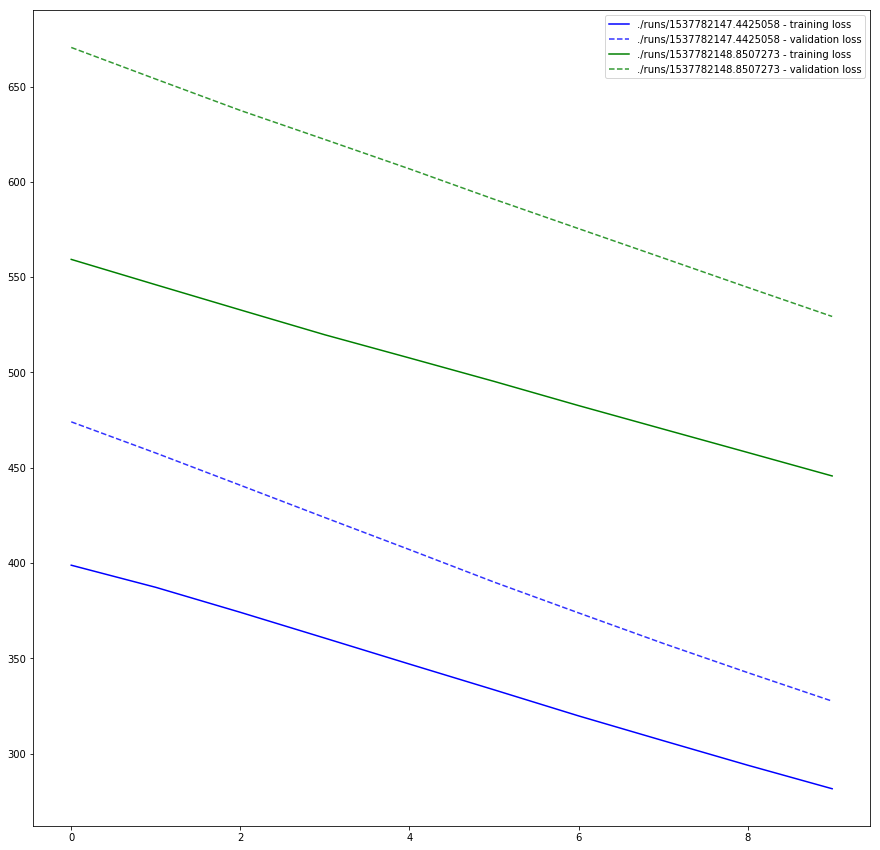

In [72]:
# Losses during training

legend_labels = []
colors = "bgrcmykbgrcmyk"
train_linestyles = ["-"] * 7 + ["-."] * 7
val_linestyles = ["--"] * 7 + [".."] * 7
plt.figure(figsize=(15,15))
for color, tl, vl, model in zip(colors, train_linestyles, val_linestyles, experiment_names):
    with open(model + "/history.pkl", "rb") as f:
        hist = pickle.load(f)
    loss = hist['loss']
    val_loss = hist['val_loss']
    plt.plot(loss, linestyle=tl, color=color)
    plt.plot(val_loss, linestyle=vl, color=color, alpha=0.8)
    legend_labels.append(model + " - training loss")
    legend_labels.append(model + " - validation loss")
plt.legend(legend_labels)
plt.show()